**Challenge 9: Redes Neuronales Convolusionales**\
Leonardo Sandoval Carranza

In [15]:
#Importamos librerias. 
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np


Importamos una serie de imagenes de una database de imagenes dentales. Estas son imagenes de tomografia computarizada obtenidas de un detector plano para colectar el haz de rayos X emitido. 

Database: https://physionet.org/content/multimodal-dental-dataset/1.0.0/

El database pertenece a 389 pacientes diferentes. Para cada paciente, puede haber varios archivos si tuvo varias visitas. Estos archivos CBCT reciben nombres según la identificación del paciente y se ordenan según la fecha de visita con un sufijo. Por ejemplo, "0021_0" indica los datos de la primera visita del paciente con ID 21, mientras que "0021_1" representa los datos de su segunda visita.

Haremos uso de PeX-ray de la base de datos la cual contiene 333 archivos. Cada una de las carpetas contiene tres subcarpetas: izquierda, central y derecha, que representan tres ángulos diferentes de exposición a la luz. La carpeta "izquierda" corresponde a una desviación hacia la izquierda de 20-25 grados, la carpeta "intermedia" corresponde a una desviación hacia la izquierda de 5-10 grados y la carpeta "derecha" corresponde a una desviación hacia la derecha de 20-25 grados. Dentro de cada una de estas carpetas, las radiografías periapicales de cada diente se almacenan en formato TIFF. El primer dígito indica si se trata de una imagen de la mandíbula superior o inferior, donde 0 representa la mandíbula inferior y 1 representa la mandíbula superior. El segundo dígito representa el número de diente específico. Por ejemplo, 0_0.tif representa la radiografía periapical del primer diente de la mandíbula inferior.

En este caso use al paciente 0008_0 (paciente 8 en su unica visita) y analice la exposicion a la luz a la izquierda y derecha sobre toda la mandibula (superior e inferior). 


(120, 160)


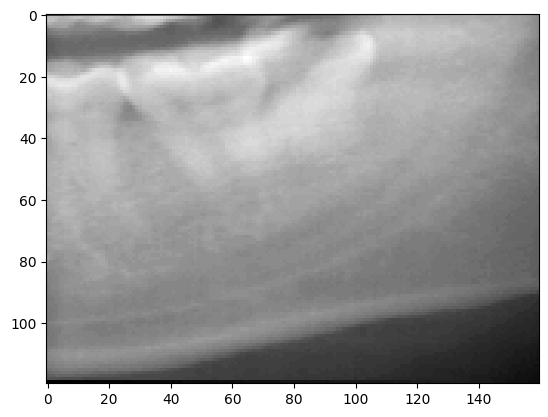

In [16]:
#Importamos las imagenes. 

def leer_imagenes_tiff(ruta_carpeta):
    imagenes = []
    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith(".tif"):
            ruta_imagen = os.path.join(ruta_carpeta, archivo)
            imagen = tiff.imread(ruta_imagen)
            imagenes.append(imagen)

    return imagenes

ruta_carpeta_left = "C:\\Users\\HP\\Desktop\\Noveno_ciclo\\reconocimiento_patrones\\Challenge_redes_neuronales\\PeX-ray_008_0_left"
ruta_carpeta_right = "C:\\Users\\HP\\Desktop\\Noveno_ciclo\\reconocimiento_patrones\\Challenge_redes_neuronales\\PeX-ray_008_0_right"

imagenes_left = leer_imagenes_tiff(ruta_carpeta_left)
imagenes_right = leer_imagenes_tiff(ruta_carpeta_right)

plt.figure
plt.imshow(imagenes_left[0],cmap="gray")
print(imagenes_left[0].shape)

In [17]:

model = models.Sequential() #Creacion secuencial, para acoplar las capas.
#Convolusion. 
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(120,160,1)))
#Añade capa de maxpooling
model.add(layers.MaxPooling2D(2,2))
#Convolusion. 
model.add(layers.Conv2D(16,(3,3),activation="relu"))
#Capa de maxpooling
model.add(layers.MaxPooling2D(2,2))
#Convolusion. 
model.add(layers.Conv2D(8,(3,3),activation="relu"))
#Aplanado de la capa. 
model.add(layers.Flatten())
    #Creacion de la primera capa, la entrada tendra la forma de la imagen, su activacion es Relu ideal para evitar la saturacion al inicio.
    #Creacion de la segunda capa, su activacion es Relu ideal para evitar la saturacion al inicio.
model.add(layers.Dense(64, activation='relu'))
    #Creacion de la segunda capa, su activacion es Relu ideal para evitar la saturacion al inicio.
model.add(layers.Dense(32, activation='relu'))
    #Creacion de la tercera capa, su activacion es softmax para la clasificacion.  
model.add(layers.Dense(10, activation='softmax'))


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Optimizador RMS prop para clasificacion. 
#Funcion perdida de enropia.
#Metrica principal es la precision. 

In [19]:
from sklearn.preprocessing import LabelEncoder

#Obtenemos las imagenes y las listas. 
imagenes = imagenes_left + imagenes_right; etiquetas = ['left'] * len(imagenes_left) + ['right'] * len(imagenes_right)
imagenes = np.array(imagenes); etiquetas = np.array(etiquetas)

In [20]:

# Dividimos en prueba y testeo con un 20% de test size.
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)

In [21]:
# Codificar las etiquetas como enteros
label_encoder = LabelEncoder();y_train_encoded = label_encoder.fit_transform(y_train); y_test_encoded = label_encoder.transform(y_test)


In [22]:
#En el anterior caso el mejor realmente se encontraba en el EPOCH 8 donde existia un alto accuracy y val_accuracy.El numero de epochs es 200. Asimismo, utilizare un callback en donde haga uso del val accuracy para ver el mejor valor de Val_accuracy (testeo) y evitar asi el overffiting.

from tensorflow.keras.callbacks import EarlyStopping

#Definición de Callback. 
# Callback para definir si existe una mejora cada 10 epochs de al menos 10% de no encontrarlo se queda con el mejor.  
early_stopping_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.10, patience=20, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

# Compilar el modelo
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con 100 epochs y el callback
model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping_callback])

# Evaluar el rendimiento del modelo en los datos de prueba
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print('Test accuracy:', test_acc)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 784ms/step - accuracy: 0.1046 - loss: 62.9804 - val_accuracy: 0.5385 - val_loss: 9.6557
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5039 - loss: 7.2642 - val_accuracy: 0.5385 - val_loss: 3.1266
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5927 - loss: 2.3929 - val_accuracy: 0.5385 - val_loss: 1.3262
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5092 - loss: 1.2833 - val_accuracy: 0.6154 - val_loss: 0.7221
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.5143 - loss: 0.7616 - val_accuracy: 0.6154 - val_loss: 0.7293
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.6632 - loss: 0.6971 - val_accuracy: 0.5385 - val_loss: 0.6181
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6971 - loss: 0.5509 - val_accuracy: 0.6923 - val_loss: 0.6202
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7206 - loss: 0.4888 - val_accuracy: 0.6923 - 

A partir del valor de training accuracy y validation accuracy se puede observar que esta overfitteado. Una opcion es que aumente aun más el numero de epocas o aumentar el numero de imagenes. Habiendo utilizado solo 64 imagenes eso expresaria que son muy pocas imagenes para el modelo. 


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

#Definición de Callback. 
# Callback para definir si existe una mejora cada 5 epochs de al menos 10% de no encontrarlo se queda con el mejor. 
# Compilar el modelo
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con 100 epochs y el callback
model.fit(X_train, y_train_encoded, epochs=40, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=None)

# Evaluar el rendimiento del modelo en los datos de prueba
test_loss_1, test_acc_1 = model.evaluate(X_test, y_test_encoded)
print('Test accuracy:', test_acc_1)

Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 681ms/step - accuracy: 0.8693 - loss: 1.1509 - val_accuracy: 0.5385 - val_loss: 109.6699
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5431 - loss: 80.0573 - val_accuracy: 0.6154 - val_loss: 2.9243
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8511 - loss: 0.7645 - val_accuracy: 0.6154 - val_loss: 4.8819
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8041 - loss: 2.3917 - val_accuracy: 0.8462 - val_loss: 4.8447
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8930 - loss: 0.2007 - val_accuracy: 0.6923 - val_loss: 5.0523
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9165 - loss: 0.1540 - val_accuracy: 0.7692 - val_loss: 5.2033
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9400 - loss: 0.1199 - val_accuracy: 0.8462 - val_loss: 5.4704
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9765 - loss: 0.0821 - val_accuracy: 0.8462 - val_lo

In [28]:
print('Test accuracy:', test_acc_1)

Test accuracy: 0.692307710647583
